# Task 1 IDL

This notebook shows (most of) the implementations for the methodolgy explained in the report. For some of the heavier tasks we use separate .py files.
Note that the most recent runs of the notebook does not match some of the tables in the report, since I forgot to set a seed in most places. However, I do keep all of the data files on which I have based most of the report
imports might be repetitive and uneeded as a result of a complex parallel developmental cycle :)

Intial look at the data 

In [1]:
from __future__ import print_function
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras import backend as K
import tensorflow as tf
import os


os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
tf.config.optimizer.set_jit(False) # This disables XLA JIT - was tried to reduce runtimes (not sure it helped) 

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)




2025-11-08 15:54:12.649787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-08 15:54:12.762776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-08 15:54:14.126964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


Create the MLP (DNN) generator

In [2]:
def create_a_dnn_sequential(input_shape, num_classes, dnn_config):
    """
    Creates a simple DNN (MLP) using the Sequential API.
    All hidden layers share the same configuration.
    """
    
    model = Sequential()
    
    # 1. Handle Input Shape
    if len(input_shape) > 1:
        model.add(Flatten(input_shape=input_shape))
    else:
        model.add(keras.layers.Input(shape=input_shape))

    # 2. Get Shared Layer Parameters from Config
    num_hidden_layers = dnn_config['num_hidden_layers']
    nodes = dnn_config['nodes_per_layer']
    activation = dnn_config.get('activation', 'relu')
    initializer = dnn_config.get('initializer', 'glorot_uniform')
    l1_reg = dnn_config.get('l1_regularization', 0.0)
    l2_reg = dnn_config.get('l2_regularization', 0.0)
    dropout_rate = dnn_config.get('dropout_rate', 0.0)

    # 3. Create Regularizer 
    kernel_reg = None
    if l1_reg > 0.0 or l2_reg > 0.0:
        kernel_reg = keras.regularizers.L1L2(l1=l1_reg, l2=l2_reg)

    # 4. Build the Hidden Layers
    for _ in range(num_hidden_layers):
        # Add the Dense layer
        model.add(Dense(
            units=nodes,
            activation=activation,
            kernel_initializer=initializer,
            kernel_regularizer=kernel_reg
        ))
        
        # Add Dropout layer 
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))

    # 5. Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # 6. Compile the Model
    model.compile(
        loss=dnn_config['loss'],
        optimizer=dnn_config['optimizer'],
        metrics=['accuracy']
    )
    
    return model

Create CNN generator

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras import regularizers 

def create_cnn(input_shape, num_classes, cnn_config):
    
    # Unpack all parameters from the config
    conv_params_list = cnn_config['conv_params_list']
    pool_layer_template = cnn_config['pool_layer_template']
    pool_flags_list = cnn_config['pool_flags_list']
    dropout_rates_list = cnn_config['dropout_rates_list']
    dense_layer_nodes = cnn_config['dense_layer_nodes']
    optimizer = cnn_config['optimizer']
    
    # Get L1/L2 values
    l1_reg = cnn_config.get('l1_reg', 0.0)
    l2_reg = cnn_config.get('l2_reg', 0.0)

    # Create the regularizer object
    kernel_reg = None
    if l1_reg > 0.0 or l2_reg > 0.0:
        kernel_reg = regularizers.L1L2(l1=l1_reg, l2=l2_reg)

    model = Sequential()
    
    # Add the first Conv2D layer
    filters, kernel_size, strides = conv_params_list[0]
    model.add(Conv2D(filters, kernel_size, strides=strides, activation='relu',
                     input_shape=input_shape, padding='valid',
                     kernel_regularizer=kernel_reg)) 

    # Add optional pooling/dropout for the first block
    if pool_flags_list[0]:
        model.add(pool_layer_template)
        model.add(Dropout(dropout_rates_list[0]))

    # Add the remaining convolutional blocks
    for i in range(1, len(conv_params_list)):
        filters, kernel_size, strides = conv_params_list[i]
        model.add(Conv2D(filters, kernel_size, strides=strides, activation='relu',
                         kernel_regularizer=kernel_reg)) 
        
        if pool_flags_list[i]:
            model.add(pool_layer_template)
            model.add(Dropout(dropout_rates_list[i]))
            
    # Add the classifier hed
    model.add(Flatten())
    model.add(Dense(dense_layer_nodes, activation='relu',
                    kernel_regularizer=kernel_reg)) 
    model.add(Dropout(dropout_rates_list[-1]))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

# Dict with CNN architectures


In [4]:
from keras import optimizers
from keras.layers import MaxPooling2D, AveragePooling2D

BEST_LR = 0.001 
FIXED_OPTIMIZER = optimizers.Adam(learning_rate=BEST_LR)


CNN_ARCHITECTURES = {
    
    # --- 1. The Baseline (Based on the Git Repo) ---
    "Baseline_Git_Repo": {
        "conv_params_list": [
            (32, (3, 3), (1, 1)), # filters=32, kernel=(3,3), strides=(1,1)
            (64, (3, 3), (1, 1))  # filters=64, kernel=(3,3), strides=(1,1)
        ],
        "pool_layer_template": MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True], # Pool only after the 2nd conv
        "dropout_rates_list": [0.0, 0.25, 0.5], 
        "dense_layer_nodes": 128,
        "optimizer": FIXED_OPTIMIZER
    },
    
    # --- 2. "Wide" Model (Bigger Filters & Dense Head) ---
    # Philosophy: More filters capture more features at each step.
    "Wide_Model": {
        "conv_params_list": [
            (64, (3, 3), (1, 1)),  # Wider start
            (128, (3, 3), (1, 1)) # Wider second layer
        ],
        "pool_layer_template": MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True],
        "dropout_rates_list": [0.0, 0.25, 0.5],
        "dense_layer_nodes": 256, # Wider dense head
        "optimizer": FIXED_OPTIMIZER
    },
    
    # --- 3. "Aggressive Reduction" Model (Pool After Each Conv) ---
    # Philosophy: Reduce the image size quickly to build more abstract features.
    "Aggressive_Reduction": {
        "conv_params_list": [
            (32, (3, 3), (1, 1)),
            (64, (3, 3), (1, 1))
        ],
        "pool_layer_template": MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [True, True], # Pool after each conv layer
        "dropout_rates_list": [0.3, 0.3, 0.5], # Dropout 0.3 after each conv block
        "dense_layer_nodes": 128,
        "optimizer": FIXED_OPTIMIZER
    },

    # --- 4. "Large Kernel" Model ---
    # Philosophy: Larger kernel (5x5) at the start to capture bigger shapes.
    "Large_Kernel_Start": {
        "conv_params_list": [
            (32, (5, 5), (1, 1)), # 5x5 kernel
            (64, (3, 3), (1, 1))
        ],
        "pool_layer_template": MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True],
        "dropout_rates_list": [0.0, 0.25, 0.5],
        "dense_layer_nodes": 128,
        "optimizer": FIXED_OPTIMIZER
    },
    
    # --- 5. "Deeper" Model (3 Conv Layers) ---
    # Philosophy: A deeper feature extractor before the dense head.
    "Deeper_3Conv_Model": {
        "conv_params_list": [
            (32, (3, 3), (1, 1)),
            (64, (3, 3), (1, 1)),
            (128, (3, 3), (1, 1)) # Third conv layer
        ],
        "pool_layer_template": MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True, True], # Pool after 2nd and 3rd convs
        "dropout_rates_list": [0.0, 0.2, 0.2, 0.5], 
        "dense_layer_nodes": 256,
        "optimizer": FIXED_OPTIMIZER
    },
    
    # --- 6. "Average Pooling" Model ---
    # Philosophy: Test if "blurring" features (Average) is better than (Max).
    "Average_Pooling_Model": {
        "conv_params_list": [
            (32, (3, 3), (1, 1)),
            (64, (3, 3), (1, 1))
        ],
        "pool_layer_template": AveragePooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True],
        "dropout_rates_list": [0.0, 0.25, 0.5],
        "dense_layer_nodes": 128,
        "optimizer": FIXED_OPTIMIZER
    },
    
    "Extra_Deep_5Conv": {
        "conv_params_list": [
            (32, (3, 3), (1, 1)),  # Conv 1
            (32, (3, 3), (1, 1)),  # Conv 2
            (64, (3, 3), (1, 1)),  # Conv 3
            (64, (3, 3), (1, 1)),  # Conv 4
            (128, (3, 3), (1, 1))  # Conv 5
        ],
        "pool_layer_template": MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True, False, True, True], # Pool after 2, 4, 5
        "dropout_rates_list": [0.0, 0.2, 0.0, 0.3, 0.4, 0.5], 
        "dense_layer_nodes": 512, # Large dense head
        "optimizer": FIXED_OPTIMIZER
    }
}

2025-11-08 15:54:16.079508: I external/local_xla/xla/service/service.cc:163] XLA service 0x31e07740 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-08 15:54:16.079527: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1762613656.274632 1131384 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-11-08 15:54:16.277589: I external/local_xla/xla/service/service.cc:163] XLA service 0x3ab5e690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-08 15:54:16.277600: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


Initally we tried to run everything in jupyeter notebook, but the search was so wide, that even after deleting all the variables the environment often crashed. The RAM itself became too fragmented to function properly.

For the real hyperparameters search loops, the code was run using separate python files - availible on the GitHub with instructions on how to run!

This code is just an example loop for the first step of MLP tunning

In [5]:
import csv
import gc
from keras import backend as K
from sklearn.model_selection import train_test_split
import time

#here we have to manualy split the validation so that we keep the repeated experiments consistent
X_train_main, X_val, y_train_main, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=67 
)

nodes_list = [64, 128, 256, 512]
dropout_list = [0, 0.2, 0.4, 0.5]
lr_list = [1.0, 0.1, 0.01, 0.001, 0.0005]
hl_list = [1, 2, 3, 4]

runs_per_set = 5

total_param_sets = (
    len(nodes_list) *
    len(dropout_list) *
    len(lr_list) *
    len(hl_list)
)

current_param_index = 0

output_filename = 'dnn_grid_search_results_GPU.csv'
csv_header = [
    'run_id', 'hidden_layers', 'nodes', 'dropout', 'lr',
    'train_accuracy', 'val_accuracy', 'fit_time_sec'
]

#Main Experiment Loop 
with open(output_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)

    for hl in hl_list:
        for nodes in nodes_list:
            for dropout in dropout_list:
                for lr in lr_list:
                    for run_id in range(1, runs_per_set + 1):
                        
                        t_start = time.time()
                        config = {
                            'optimizer': optimizers.Adam(learning_rate=lr),
                            'loss': 'categorical_crossentropy',
                            'num_hidden_layers': hl,
                            'nodes_per_layer': nodes,
                            'activation': 'relu',
                            'initializer': 'he_uniform',
                            'dropout_rate': dropout
                        }
                        model = create_a_dnn_sequential((28, 28), num_classes, config)
                        t_created = time.time()

                        history = model.fit(
                            X_train_main, y_train_main,
                            epochs=15,
                            verbose=0,
                            validation_data=(X_val, y_val),
                            batch_size=1024
                        )
                        t_fit = time.time()

                        val_accuracy = max(history.history['val_accuracy'])
                        train_accuracy = max(history.history['accuracy'])

                        result_row = [
                            run_id, hl, nodes, dropout, lr,
                            train_accuracy, val_accuracy, t_fit - t_created
                        ]
                        writer.writerow(result_row)
                        f.flush()

                        # Memory cleanup
                        del history
                        del val_accuracy
                        del train_accuracy
                        del model
                        del config
                        K.clear_session()
                        gc.collect()
                    
                    # Corrected progress update
                    current_param_index += 1
                    percent = (current_param_index / total_param_sets) * 100
                    print(
                        f"Completed param set {current_param_index}/{total_param_sets} "
                        f"({percent:.1f}%): hl={hl}, nodes={nodes}, dropout={dropout}, lr={lr}"
                    )


print(f"\n--- Experiment complete. Results saved to {output_filename} ---")
results_df = pd.read_csv(output_filename)

print("\n--- Top Results (Raw) ---")
print(results_df.sort_values(by='val_accuracy', ascending=False).head(20))

print("\n--- Best Performing Combinations (Averaged) ---")
avg_results = results_df.groupby(
    ['hidden_layers', 'nodes', 'dropout', 'lr']
)[['train_accuracy', 'val_accuracy']].mean()
print(avg_results.sort_values(by='val_accuracy', ascending=False).head(10))

/home/ivanb/tf-venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-08 15:54:17.794575: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-08 15:54:17.848786: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-11-08 15:54:18.106048: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_133', 4 bytes spill stores, 4 bytes spill loads

2025-11-08 15:54:18.321801: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memo

Completed param set 1/320 (0.3%): hl=1, nodes=64, dropout=0, lr=1.0


KeyboardInterrupt: 

In the next section we process the data obtained from the experiments

# Tables for DNN (MLP)

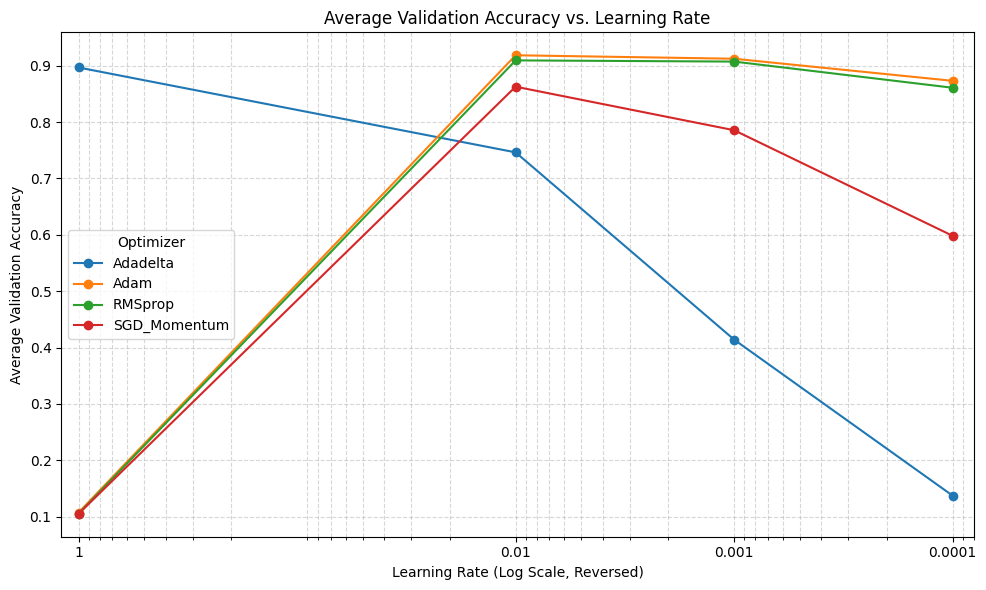

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
df = pd.read_csv("cnn_baseline_opt_search.csv")

# Calculate the average validation accuracy
avg_accuracy = df.groupby(['optimizer', 'lr'])['val_accuracy'].mean().reset_index()

# Rename for clarity
avg_accuracy.rename(columns={'val_accuracy': 'average_val_accuracy'}, inplace=True)

# Get a list of unique optimizers
optimizers = avg_accuracy['optimizer'].unique()

# Get the unique lr values for setting ticks
lr_values = avg_accuracy['lr'].unique()

# Create the plot
plt.figure(figsize=(10, 6))
ax = plt.gca() # Get current axes

# Plot a separate line for each optimizer
for optimizer in optimizers:
    # Get data for the current optimizer
    optimizer_data = avg_accuracy[avg_accuracy['optimizer'] == optimizer]
    # Sort by 'lr' to ensure the line plots correctly
    optimizer_data = optimizer_data.sort_values(by='lr')
    
    # Plot lr vs. average_val_accuracy
    ax.plot(optimizer_data['lr'], 
            optimizer_data['average_val_accuracy'], 
            marker='o',  
            label=optimizer)

# Set the x-axis to a log scale
ax.set_xscale('log')

# Reverse the x-axis (from max to min)
sorted_lrs = np.sort(lr_values)
ax.set_xlim(sorted_lrs.max() * 1.2, sorted_lrs.min() * 0.8) 

# Format x-axis ticks to show numbers instead of 10^-x
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%g')) # Use %g for clean number format
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
plt.xticks(lr_values) # Ensure all lr values are shown as ticks

# Set labels and title
ax.set_xlabel('Learning Rate (Log Scale, Reversed)')
ax.set_ylabel('Average Validation Accuracy')
ax.set_title('Average Validation Accuracy vs. Learning Rate')

# Add a legend
ax.legend(title='Optimizer')

# Add gridlines
ax.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()

In [ ]:
import pandas as pd

df_nn = pd.read_csv("haleeluyahhh.csv")

# Define the configuration columns
config_cols = ['hidden_layers', 'nodes', 'dropout', 'lr']

# Group by the configuration and calculate average scores
agg_scores = df_nn.groupby(config_cols).agg(
    avg_val_accuracy=('val_accuracy', 'mean'),
    avg_fit_time_sec=('fit_time_sec', 'mean')
).reset_index()

# Sort by the best average validation accuracy
agg_scores = agg_scores.sort_values(by='avg_val_accuracy', ascending=False)

# Get the Top 3 best configurations
top_3_scores = agg_scores.head(3)

# Find the best 2-layer model overall
best_2_layer = agg_scores[
    agg_scores['hidden_layers'] == 2
].nlargest(1, 'avg_val_accuracy')

# Find the best 4-layer, 64-node model
best_4_layer_64_node = agg_scores[
    (agg_scores['hidden_layers'] == 4) & (agg_scores['nodes'] == 64)
].nlargest(1, 'avg_val_accuracy')

# 3. Combine the tables
# Use concat and then remove duplicates in case the "variety" rows
# were already in the top 3.
combined_table = pd.concat([
    top_3_scores, 
    best_2_layer, 
    best_4_layer_64_node
]).drop_duplicates().sort_values(by='avg_val_accuracy', ascending=False)

# Define column order and headers for output
final_cols = config_cols + ['avg_val_accuracy', 'avg_fit_time_sec']
headers = ['Hidden Layers', 'Nodes', 'Dropout', 'LR', 'Avg Val Acc', 'Avg Fit Time (s)']
col_format = 'llllll'

print("--- Top Performers with 'Variety' Rows ---")
print(combined_table[final_cols].to_string(float_format='%.4f'))

--- Top Performers with 'Variety' Rows ---
     hidden_layers  nodes  dropout     lr  avg_val_accuracy  avg_fit_time_sec
301              4    512   0.0000 0.0010            0.8965            7.2879
225              3    512   0.2000 0.0005            0.8959           10.0985
221              3    512   0.0000 0.0010            0.8957            7.2181
146              2    512   0.2000 0.0010            0.8946            8.9355
242              4     64   0.0000 0.0100            0.8800            7.5609


In [ ]:
df_dnn2 = pd.read_csv("dnn_part2_search_results.csv")

# Define the configuration columns
config_cols = ['optimizer', 'activation', 'initializer', 'l1_reg', 'l2_reg']

# Group by the configuration and calculate average scores
agg_scores = df_dnn2.groupby(config_cols).agg(
    avg_val_accuracy=('val_accuracy', 'mean')
).reset_index()

# Sort by the best average validation accuracy
agg_scores = agg_scores.sort_values(by='avg_val_accuracy', ascending=False)

# Get the Top 3 best configurations
top_3_scores = agg_scores.head(3)

# Select only the columns for the final table
final_table_cols = config_cols + ['avg_val_accuracy']
final_table = top_3_scores[final_table_cols]

#Print the simple table 
print("--- Top 3 Configurations (Reduced Columns) ---")
print(final_table.to_string(float_format='%.4f'))

--- Top 3 Configurations (Reduced Columns) ---
   optimizer activation     initializer  l1_reg  l2_reg  avg_val_accuracy
12      Adam       tanh      he_uniform  0.0000  0.0000            0.8966
0       Adam       relu  glorot_uniform  0.0000  0.0000            0.8953
4       Adam       relu      he_uniform  0.0000  0.0000            0.8944



# Table architectures

In [10]:
df_arch = pd.read_csv("cnn_phase2_architecture_search.csv")

# Group by architecture name and calculate the mean for the relevant metrics
agg_scores = df_arch.groupby('arch_name').agg(
    avg_train_accuracy=('train_accuracy', 'mean'),
    avg_val_accuracy=('val_accuracy', 'mean'),
    avg_fit_time_sec=('fit_time_sec', 'mean')
).reset_index()

# Sort the results by the average validation accuracy in descending order
agg_scores = agg_scores.sort_values(by='avg_val_accuracy', ascending=False)

# Select only the columns you requested for the final table
final_table = agg_scores[['arch_name', 'avg_train_accuracy', 'avg_val_accuracy', 'avg_fit_time_sec']]
print(final_table)


               arch_name  avg_train_accuracy  avg_val_accuracy  \
6             Wide_Model            0.955173          0.927056   
1  Average_Pooling_Model            0.933420          0.923056   
2      Baseline_Git_Repo            0.932309          0.922667   
3     Deeper_3Conv_Model            0.911593          0.919167   
5     Large_Kernel_Start            0.922420          0.918389   
0   Aggressive_Reduction            0.883901          0.903000   
4       Extra_Deep_5Conv            0.844636          0.880556   

   avg_fit_time_sec  
6         81.473860  
1         33.020536  
2         39.722800  
3         52.713244  
5         35.156677  
0         22.238187  
4         40.369150  


# Final Table CNNs

In [ ]:
df_reg = pd.read_csv("cnn_phase2_regularization_search.csv")

# Define the configuration columns
config_cols = ['conv_dropout', 'dense_dropout', 'l1_reg', 'l2_reg']

# Group by the configuration and calculate average scores
agg_scores = df_reg.groupby(config_cols).agg(
    avg_train_accuracy=('train_accuracy', 'mean'),
    avg_val_accuracy=('val_accuracy', 'mean'),
    avg_fit_time_sec=('fit_time_sec', 'mean')
).reset_index()

# Sort by the best average validation accuracy
agg_scores = agg_scores.sort_values(by='avg_val_accuracy', ascending=False)

# Get the Top 3 best configurations
top_3_scores = agg_scores.head(3)

print("--- Top 3 Configurations ---")
print(top_3_scores.to_string(float_format='%.4f'))

--- Top 3 Configurations ---
    conv_dropout  dense_dropout  l1_reg  l2_reg  avg_train_accuracy  avg_val_accuracy  avg_fit_time_sec
12        0.2500         0.5000  0.0000  0.0000              0.9507            0.9267           78.6165
21        0.4000         0.5000  0.0000  0.0000              0.9431            0.9265           78.5716
9         0.2500         0.3000  0.0000  0.0000              0.9671            0.9264           77.9191


# Training on CIFAR-10

Here we load in our CIFAR-10 dataset

In [ ]:
from keras.datasets import cifar10

num_classes = 10 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print(f'Original y_train shape: {y_train.shape}')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f'Corrected y_train shape: {y_train.shape}')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Original y_train shape: (50000, 1)
Corrected y_train shape: (50000, 10)


3 MLPs to be tested on CIFAR-10


In [17]:

BEST_HL = 3
BEST_NODES = 256
BEST_DROPOUT = 0.2
BEST_LR = 0.001 


best_dnn_configs = {
    
    "DNN_1_Best_Performer": {
        'optimizer': keras.optimizers.Adam(learning_rate=BEST_LR),
        'loss': 'categorical_crossentropy',
        'num_hidden_layers': BEST_HL,
        'nodes_per_layer': BEST_NODES,
        'dropout_rate': BEST_DROPOUT,
        'activation': 'tanh',
        'initializer': 'he_uniform',
        'l1_regularization': 0.0,
        'l2_regularization': 0.0
    },
    
    "DNN_2_Best_RMSprop": {
        'optimizer': keras.optimizers.RMSprop(learning_rate=BEST_LR),
        'loss': 'categorical_crossentropy',
        'num_hidden_layers': BEST_HL,
        'nodes_per_layer': BEST_NODES,
        'dropout_rate': BEST_DROPOUT,
        'activation': 'relu',
        'initializer': 'he_uniform',
        'l1_regularization': 0.0,
        'l2_regularization': 0.0
    },
    
    "DNN_3_Best_Regularized": {
        'optimizer': keras.optimizers.Adam(learning_rate=BEST_LR),
        'loss': 'categorical_crossentropy',
        'num_hidden_layers': BEST_HL,
        'nodes_per_layer': BEST_NODES,
        'dropout_rate': BEST_DROPOUT,
        'activation': 'relu',
        'initializer': 'glorot_uniform',
        'l1_regularization': 0.0,
        'l2_regularization': 0.001 
    }
}



3 CNNs to be tested

In [ ]:
BEST_LR = 0.001

def OPTIMIZER_FACTORY():
    return keras.optimizers.Adam(learning_rate=BEST_LR)

best_cnn_configs = {

    # --- 1. Baseline CNN ---
    "Baseline_Git_Repo": {
        "conv_params_list": [
            (32, (3, 3), (1, 1)),
            (64, (3, 3), (1, 1))
        ],
        "pool_layer_template": lambda: keras.layers.MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True],
        "dropout_rates_list": [0.0, 0.25, 0.5],
        "dense_layer_nodes": 128,
        "optimizer": OPTIMIZER_FACTORY     
    },

    # --- 2. Wide Model ---
    "Wide_Model": {
        "conv_params_list": [
            (64, (3, 3), (1, 1)),
            (128, (3, 3), (1, 1))
        ],
        "pool_layer_template": lambda: keras.layers.MaxPooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True],
        "dropout_rates_list": [0.0, 0.25, 0.5],
        "dense_layer_nodes": 256,
        "optimizer": OPTIMIZER_FACTORY
    },

    # --- 3. Average Pooling Model ---
    "Average_Pooling_Model": {
        "conv_params_list": [
            (32, (3, 3), (1, 1)),
            (64, (3, 3), (1, 1))
        ],
        "pool_layer_template": lambda: keras.layers.AveragePooling2D(pool_size=(2, 2)),
        "pool_flags_list": [False, True],
        "dropout_rates_list": [0.0, 0.25, 0.5],
        "dense_layer_nodes": 128,
        "optimizer": OPTIMIZER_FACTORY
    }
}


CNN creator had to be a bit reworked to work in the jupyter notebook, since there was some issue with layer share-ing.

In [15]:
def create_cnn(input_shape, num_classes, cnn_config):

    conv_params_list = cnn_config['conv_params_list']
    pool_layer_factory = cnn_config['pool_layer_template']   
    pool_flags_list = cnn_config['pool_flags_list']
    dropout_rates_list = cnn_config['dropout_rates_list']
    dense_layer_nodes = cnn_config['dense_layer_nodes']

    # Optimizer is a factory
    opt = cnn_config['optimizer']()

    # Regularizers
    l1_reg = cnn_config.get('l1_reg', 0.0)
    l2_reg = cnn_config.get('l2_reg', 0.0)
    kernel_reg = regularizers.L1L2(l1=l1_reg, l2=l2_reg) if (l1_reg or l2_reg) else None

    model = Sequential()

    # First conv
    filters, kernel_size, strides = conv_params_list[0]
    model.add(Conv2D(filters, kernel_size, strides=strides,
                     activation='relu', input_shape=input_shape,
                     padding='valid', kernel_regularizer=kernel_reg))

    if pool_flags_list[0]:
        model.add(pool_layer_factory())
        model.add(Dropout(dropout_rates_list[0]))

    # Remaining conv blocks
    for i in range(1, len(conv_params_list)):
        filters, kernel_size, strides = conv_params_list[i]
        model.add(Conv2D(filters, kernel_size, strides=strides,
                         activation='relu', kernel_regularizer=kernel_reg))

        if pool_flags_list[i]:
            model.add(pool_layer_factory())
            model.add(Dropout(dropout_rates_list[i]))

    # Dense head
    model.add(Flatten())
    model.add(Dense(dense_layer_nodes, activation='relu',
                    kernel_regularizer=kernel_reg))
    model.add(Dropout(dropout_rates_list[-1]))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model


# Transferring the model

In [16]:

input_shape = (32, 32, 3)

# Loop 1: Train and Evaluate DNNs 
print("--- STARTING FINAL DNN EVALUATION ---")
for model_name, config in best_dnn_configs.items():
    print(f"\nTraining model: {model_name}...")
    
    model = create_a_dnn_sequential(
        input_shape=input_shape,
        num_classes=num_classes,
        dnn_config=config
    )
    
    # Train the model on the FULL training set
    history = model.fit(
        x_train, y_train,  
        epochs=25,
        verbose=0,
        batch_size=1024

    )
    
    # Get the final accuracy on the training set
    final_train_acc = history.history['accuracy'][-1]
    
    # Evaluate the final model on the TEST SET 
    test_results = model.evaluate(x_test, y_test, verbose=0, batch_size=1024)
    final_test_acc = test_results[1] 
    
    print(f"  > Final Train Accuracy: {final_train_acc:.4f}")
    print(f"  > Final TEST Accuracy:  {final_test_acc:.4f}")


# Loop 2: Train and Evaluate CNNs
print("\n\n--- STARTING FINAL CNN EVALUATION ---")
for model_name, config in best_cnn_configs.items():
    print(f"\nTraining model: {model_name}...")
    model = create_cnn(
        input_shape=input_shape,
        num_classes=num_classes,
        cnn_config=config
    )
    
    # Train the model on the FULL training set
    history = model.fit(
        x_train, y_train, 
        epochs=25,
        verbose=0,
        batch_size=1024
    )
    
    # Get the final accuracy on the training set
    final_train_acc = history.history['accuracy'][-1]

    #Evaluate the final model on the TEST SET
    test_results = model.evaluate(x_test, y_test, verbose=0, batch_size=1024)
    final_test_acc = test_results[1] 

    print(f"  > Final Train Accuracy: {final_train_acc:.4f}")
    print(f"  > Final TEST Accuracy:  {final_test_acc:.4f}")

print("\n\n--- Final Evaluation Complete ---")

--- STARTING FINAL DNN EVALUATION ---

Training model: DNN_1_Best_Performer...


/home/ivanb/tf-venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-08 15:55:04.063131: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1452', 80 bytes spill stores, 80 bytes spill loads

2025-11-08 15:55:04.118248: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_204', 11296 bytes spill stores, 11492 bytes spill loads

2025-11-08 15:55:04.173900: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1468', 1004 bytes spill

  > Final Train Accuracy: 0.4397
  > Final TEST Accuracy:  0.4562

Training model: DNN_2_Best_RMSprop...


2025-11-08 15:55:23.537675: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_76', 12 bytes spill stores, 12 bytes spill loads



  > Final Train Accuracy: 0.3897
  > Final TEST Accuracy:  0.4114

Training model: DNN_3_Best_Regularized...
  > Final Train Accuracy: 0.4651
  > Final TEST Accuracy:  0.4901


--- STARTING FINAL CNN EVALUATION ---

Training model: Baseline_Git_Repo...


/home/ivanb/tf-venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-08 15:55:35.837977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1253', 80 bytes spill stores, 80 bytes spill loads

2025-11-08 15:55:36.003723: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1253', 1048 bytes spill stores, 1048 bytes spill loads

2025-11-08 15:55:42.553988: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in 

  > Final Train Accuracy: 0.7512
  > Final TEST Accuracy:  0.7088

Training model: Wide_Model...


2025-11-08 15:56:32.200247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1253', 80 bytes spill stores, 80 bytes spill loads

2025-11-08 15:56:32.251104: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1171', 10152 bytes spill stores, 10356 bytes spill loads

2025-11-08 15:56:32.373557: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1253', 1048 bytes spill stores, 1048 bytes spill loads

2025-11-08 15:56:44.381986: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1171', 12 bytes spill stores, 12 bytes spill loads

2025-11-08 15:56:44.403844: I 

  > Final Train Accuracy: 0.8365
  > Final TEST Accuracy:  0.7219

Training model: Average_Pooling_Model...
  > Final Train Accuracy: 0.6358
  > Final TEST Accuracy:  0.6664


--- Final Evaluation Complete ---
